# Reward v1 vs Reward v2 Comparison

Use this notebook to compare two experiments across execution, regime, and stability layers. Edit only the parameters in the next cell.


In [1]:
from pathlib import Path

# ---------------------------------------------------------------------------
# Parameters (edit experiment IDs and optional labels)
# ---------------------------------------------------------------------------
CANDIDATE_EXPERIMENT_ID = "9da221f7c2d73dd15d90c280297cffa8ec3b2a7429135b67e68915edbbab4a94"
BASELINE_EXPERIMENT_ID = "95f7b82c1f3a11bc498ab3daacc43a2d43e786236191e6e820d8ff49d5899138"

CANDIDATE_LABEL = "Candidate (reward_v2)"
BASELINE_LABEL = "Baseline (reward_v1)"

EXPORT_DIR = Path("notebooks/_out")
STRICT = False

EXPORT_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
import json
import sys
import warnings
from pathlib import Path
from typing import Any, Iterable, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 5)


def _resolve_project_root(start: Path | None = None) -> Path:
    start = start or Path().resolve()
    for candidate in [start, *start.parents]:
        if (candidate / "research").exists() and (candidate / "scripts").exists():
            return candidate
    return start


PROJECT_ROOT = _resolve_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

try:
    from research.experiments.registry import ExperimentRegistry
except Exception as exc:  # pragma: no cover - notebook fallback
    warnings.warn(f"Could not import ExperimentRegistry: {exc}")
    ExperimentRegistry = None

REGISTRY = ExperimentRegistry() if ExperimentRegistry else None
SHADOW_ROOT = PROJECT_ROOT / ".quanto_data" / "shadow"
KNOWN_ARTIFACT_HINTS = [
    "evaluation/metrics.json",
    "evaluation/regime_slices.json",
    "evaluation/timeseries.json",
    "promotion/qualification_report.json",
    "runs/rollout.json",
]



def _has_known_artifacts(path: Path) -> bool:
    return any((path / rel).exists() for rel in KNOWN_ARTIFACT_HINTS)


def resolve_experiment_dir(experiment_id: str) -> Path:
    token = (experiment_id or "").strip()
    if not token:
        raise ValueError("experiment_id must be provided")
    if REGISTRY:
        try:
            record = REGISTRY.resolve_identifier(token)
            print(f"Resolved {token} via registry → {record.root}")
            return record.root
        except FileNotFoundError:
            pass
    search_roots = [
        PROJECT_ROOT / ".quanto_data" / "experiments",
        PROJECT_ROOT / ".quanto" / "experiments",
        PROJECT_ROOT / "experiments",
        PROJECT_ROOT / "orchestration" / "out",
    ]
    for root in search_roots:
        candidate = root / token
        if candidate.exists() and _has_known_artifacts(candidate):
            print(f"Resolved {token} via filesystem scan → {candidate}")
            return candidate
    message = f"Artifacts for {token} were not found in registry or search roots."
    if STRICT:
        raise FileNotFoundError(message)
    warnings.warn(message)
    return PROJECT_ROOT / token


candidate_dir = resolve_experiment_dir(CANDIDATE_EXPERIMENT_ID)
baseline_dir = resolve_experiment_dir(BASELINE_EXPERIMENT_ID)
print(f"Candidate directory: {candidate_dir}")
print(f"Baseline directory:  {baseline_dir}")


Resolved 9da221f7c2d73dd15d90c280297cffa8ec3b2a7429135b67e68915edbbab4a94 via registry → /Users/ahmed/PycharmProjects/Quanto/.quanto_data/experiments/9da221f7c2d73dd15d90c280297cffa8ec3b2a7429135b67e68915edbbab4a94
Resolved 95f7b82c1f3a11bc498ab3daacc43a2d43e786236191e6e820d8ff49d5899138 via registry → /Users/ahmed/PycharmProjects/Quanto/.quanto_data/experiments/95f7b82c1f3a11bc498ab3daacc43a2d43e786236191e6e820d8ff49d5899138
Candidate directory: /Users/ahmed/PycharmProjects/Quanto/.quanto_data/experiments/9da221f7c2d73dd15d90c280297cffa8ec3b2a7429135b67e68915edbbab4a94
Baseline directory:  /Users/ahmed/PycharmProjects/Quanto/.quanto_data/experiments/95f7b82c1f3a11bc498ab3daacc43a2d43e786236191e6e820d8ff49d5899138


In [3]:
ARTIFACT_CANDIDATES: dict[str, list[str]] = {
    "metrics": ["evaluation/metrics.json", "eval/metrics.json"],
    "regime_slices": ["evaluation/regime_slices.json", "eval/regime_slices.json"],
    "timeseries": ["evaluation/timeseries.json", "evaluation/time_series.json"],
    "rollout": ["runs/rollout.json", "evaluation/rollout.json"],
    "qualification": [
        "promotion/qualification_report.json",
        "qualification/report.json",
    ],
    "execution_metrics": ["evaluation/execution_metrics.json", "execution/metrics.json"],
}


def load_json(path: Path) -> dict[str, Any] | None:
    if not path.exists():
        return None
    try:
        return json.loads(path.read_text(encoding="utf-8"))
    except json.JSONDecodeError as exc:
        warnings.warn(f"Failed to parse {path}: {exc}")
        return None


def read_artifact(exp_dir: Path, rel_paths: Sequence[str]) -> dict[str, Any] | None:
    for rel in rel_paths:
        candidate = exp_dir / rel
        payload = load_json(candidate)
        if payload is not None:
            return payload
    return None


def _load_shadow_execution_metrics(exp_dir: Path) -> dict[str, Any] | None:
    exp_id = exp_dir.name
    shadow_dir = SHADOW_ROOT / exp_id
    if not shadow_dir.exists():
        return None
    replay_dirs = sorted(shadow_dir.glob("replay_*"))
    for run_dir in reversed(replay_dirs):
        payload = load_json(run_dir / "execution_metrics.json")
        if payload is not None:
            return payload
    return None


def collect_artifacts(exp_dir: Path) -> dict[str, dict[str, Any] | None]:
    artifacts = {name: read_artifact(exp_dir, rels) for name, rels in ARTIFACT_CANDIDATES.items()}
    if artifacts.get("execution_metrics") is None:
        artifacts["execution_metrics"] = _load_shadow_execution_metrics(exp_dir)
    return artifacts


candidate_artifacts = collect_artifacts(candidate_dir)
baseline_artifacts = collect_artifacts(baseline_dir)
print("Loaded artifacts:")
print("  Candidate →", {k: v is not None for k, v in candidate_artifacts.items()})
print("  Baseline  →", {k: v is not None for k, v in baseline_artifacts.items()})


Loaded artifacts:
  Candidate → {'metrics': True, 'regime_slices': True, 'timeseries': True, 'rollout': True, 'qualification': True, 'execution_metrics': True}
  Baseline  → {'metrics': True, 'regime_slices': True, 'timeseries': True, 'rollout': True, 'qualification': True, 'execution_metrics': True}


In [4]:
from collections.abc import Mapping


def dig(payload: Mapping | None, path: Sequence[str]) -> Any:
    current: Any = payload
    for key in path:
        if not isinstance(current, Mapping):
            return None
        current = current.get(key)
    return current


def get_first(mapping: Mapping | None, keys: Sequence[str], default: Any = None) -> Any:
    if not isinstance(mapping, Mapping):
        return default
    for key in keys:
        if key in mapping:
            return mapping[key]
    return default


def extract_execution_summary(
    artifacts: dict[str, Any],
    *,
    role_key: str = "candidate",
    peer_qualification: Mapping | None = None,
    peer_role_key: str | None = None,
) -> dict[str, Any]:
    summary_paths = [
        ["qualification", "execution_qualification", role_key, "summary"],
        ["execution_metrics", "summary"],
        ["execution_metrics"],
    ]
    summary: Mapping | None = None
    for path in summary_paths:
        summary = dig(artifacts, path)
        if isinstance(summary, Mapping):
            break
    if summary is None and peer_qualification is not None and peer_role_key:
        summary = dig(peer_qualification, ["execution_qualification", peer_role_key, "summary"])
    if not isinstance(summary, Mapping):
        return {}
    keys = [
        "fill_rate",
        "reject_rate",
        "partial_fill_rate",
        "avg_slippage_bps",
        "p95_slippage_bps",
        "total_fees",
        "turnover_realized",
        "execution_halts",
    ]
    result = {k: summary.get(k) for k in keys}
    result["source"] = summary_paths[0][1] if summary_paths else "unknown"
    return result


def extract_regime_frame(artifacts: dict[str, Any]) -> pd.DataFrame:
    slices = dig(artifacts, ["regime_slices", "performance_by_regime"]) or {}
    if not isinstance(slices, Mapping):
        return pd.DataFrame()
    frame = pd.DataFrame(slices).T
    return frame.sort_index()


def build_step_frame(artifacts: dict[str, Any]) -> pd.DataFrame:
    series_candidates = []
    rollout = artifacts.get("rollout")
    if isinstance(rollout, Mapping):
        series_candidates.append(rollout.get("series"))
    series_candidates.append(artifacts.get("timeseries"))
    series: Mapping | None = None
    for candidate in series_candidates:
        if isinstance(candidate, Mapping) and candidate:
            series = candidate
            break
    if not isinstance(series, Mapping):
        return pd.DataFrame()
    max_len = max((len(v) for v in series.values() if isinstance(v, Sequence)), default=0)
    df = pd.DataFrame(index=range(max_len))

    def assign(name: str, values: Sequence | None) -> None:
        if values is None:
            return
        df[name] = pd.Series(values)

    assign("timestamp", pd.to_datetime(series.get("timestamps")))
    assign("account_value", series.get("account_value"))
    assign("returns", series.get("returns"))
    assign("transaction_costs", series.get("transaction_costs"))
    assign("exposure", series.get("exposures"))

    weights = series.get("weights")
    if isinstance(weights, Mapping) and weights:
        symbols = sorted(weights)
        matrix = np.column_stack([weights[sym] for sym in symbols])
        turnover = 0.5 * np.abs(np.diff(matrix, axis=0)).sum(axis=1)
        turnover = np.concatenate([[0.0], turnover])
        df["turnover"] = pd.Series(turnover)
        df["max_weight"] = pd.Series(matrix.max(axis=1))
        top_n = np.sort(matrix, axis=1)[:, -min(5, matrix.shape[1]):]
        df["top5_weight"] = pd.Series(top_n.sum(axis=1))

    if "account_value" in df:
        rolling_max = df["account_value"].cummax().replace(0, np.nan)
        df["drawdown"] = 1.0 - (df["account_value"] / rolling_max)

    regime = series.get("regime")
    if isinstance(regime, Mapping) and isinstance(regime.get("values"), Sequence):
        values = np.array(regime["values"], dtype=float)
        feature_names = regime.get("feature_names") or [f"regime_{i}" for i in range(values.shape[1])]
        for idx, feature in enumerate(feature_names):
            if idx < values.shape[1]:
                df[f"regime_{feature}"] = pd.Series(values[:, idx])

    return df


def summarize_stability(df: pd.DataFrame) -> dict[str, Any]:
    summary: dict[str, Any] = {"steps": int(len(df))}
    if "turnover" in df:
        summary["avg_turnover"] = float(df["turnover"].mean())
        summary["p95_turnover"] = float(df["turnover"].quantile(0.95))
        summary["max_turnover"] = float(df["turnover"].max())
    if "drawdown" in df:
        summary["max_drawdown"] = float(df["drawdown"].max())
        summary["avg_drawdown"] = float(df["drawdown"].mean())
    if "account_value" in df and df["account_value"].notna().any():
        start = df["account_value"].dropna().iloc[0]
        end = df["account_value"].dropna().iloc[-1]
        summary["total_return"] = float(end / start - 1.0) if start else None
    if "returns" in df and df["returns"].notna().any():
        ann_factor = 252 ** 0.5
        summary["volatility_ann"] = float(df["returns"].std() * ann_factor)
        mean = df["returns"].mean()
        std = df["returns"].std()
        summary["sharpe"] = float(mean / std * np.sqrt(252)) if std else None
    if "max_weight" in df:
        summary["avg_max_weight"] = float(df["max_weight"].mean())
    if "top5_weight" in df:
        summary["avg_top5_weight"] = float(df["top5_weight"].mean())
    if "exposure" in df:
        summary["avg_exposure"] = float(df["exposure"].mean())
    return summary


In [5]:
shared_qualification = candidate_artifacts.get("qualification") or {}
layer1_rows: list[dict[str, Any]] = []
for label, artifacts, role_key, peer_role in [
    (BASELINE_LABEL, baseline_artifacts, "candidate", "baseline"),
    (CANDIDATE_LABEL, candidate_artifacts, "candidate", None),
]:
    summary = extract_execution_summary(
        artifacts,
        role_key=role_key,
        peer_qualification=shared_qualification,
        peer_role_key=peer_role,
    )
    summary["label"] = label
    layer1_rows.append(summary)

layer1_df = pd.DataFrame(layer1_rows).set_index("label") if layer1_rows else pd.DataFrame()
display(layer1_df)

if all(idx in layer1_df.index for idx in [BASELINE_LABEL, CANDIDATE_LABEL]):
    numeric_cols = layer1_df.select_dtypes(include=[np.number]).columns
    layer1_delta = layer1_df.loc[CANDIDATE_LABEL, numeric_cols] - layer1_df.loc[BASELINE_LABEL, numeric_cols]
else:
    layer1_delta = pd.Series(dtype=float)

if not layer1_delta.empty:
    commentary = [
        f"Turnover delta: {layer1_delta.get('turnover_realized', float('nan')):+.3f}",
        f"Fill-rate delta: {layer1_delta.get('fill_rate', float('nan')):+.3f}",
        f"Total fees delta: {layer1_delta.get('total_fees', float('nan')):+.3f}",
    ]
else:
    commentary = ["Execution metrics unavailable for comparison."]

display(Markdown("".join(f"* {line}" for line in commentary)))

,fill_rate,reject_rate,partial_fill_rate,avg_slippage_bps,p95_slippage_bps,total_fees,turnover_realized,execution_halts,source
label,,,,,,,,,
Baseline (reward_v1),1.0,0.0,0.0,0.0,0.0,0.0,6.583294,0,execution_qualification
Candidate (reward_v2),1.0,0.0,0.0,0.0,0.0,0.0,5.674176,0,execution_qualification


* Turnover delta: -0.909* Fill-rate delta: +0.000* Total fees delta: +0.000

Baseline (reward_v1)                                      \
                 avg_exposure avg_turnover max_drawdown    sharpe   
high_vol             0.193608     0.035349     0.055690  0.204665   
low_vol              0.286315     0.024105     0.047777  0.306390   
mid_vol              0.259379     0.023019     0.047455  1.701175   

                                     Candidate (reward_v2)               \
         total_return volatility_ann          avg_exposure avg_turnover   
high_vol     0.015484       0.066166              0.233827     0.008060   
low_vol      0.019153       0.051644              0.247939     0.025800   
mid_vol      0.117751       0.050735              0.247176     0.023168   

                                                             
         max_drawdown    sharpe total_return volatility_ann  
high_vol     0.103402 -0.131664    -0.019429       0.083611  
low_vol      0.072188  0.091924     0.004481       0.051666  
mid_vol      0.056353  1.241351     0.082849       0.049976

,avg_exposure,avg_turnover,max_drawdown,sharpe,total_return,volatility_ann
high_vol,0.040219,-0.027289,0.047712,-0.336329,-0.034913,0.017445
low_vol,-0.038376,0.001695,0.024411,-0.214466,-0.014672,0.000022
mid_vol,-0.012203,0.000149,0.008898,-0.459824,-0.034902,-0.000759


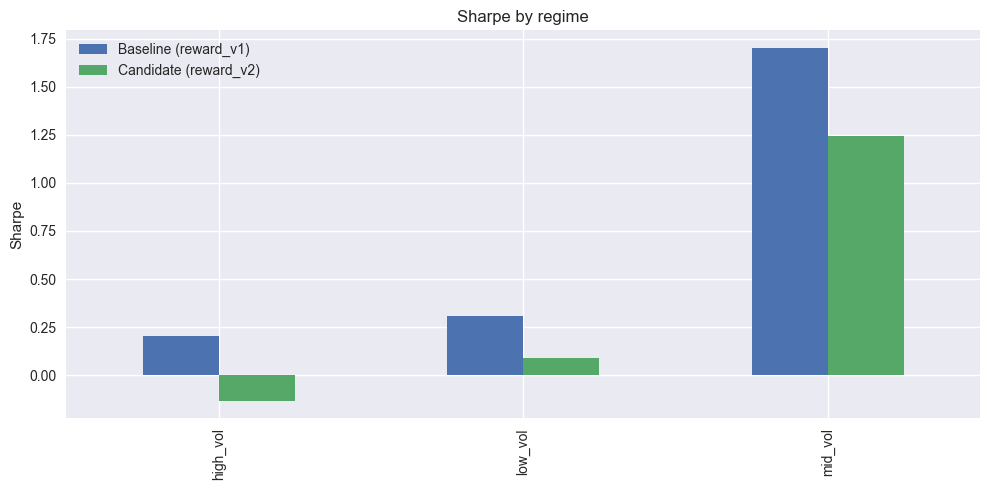

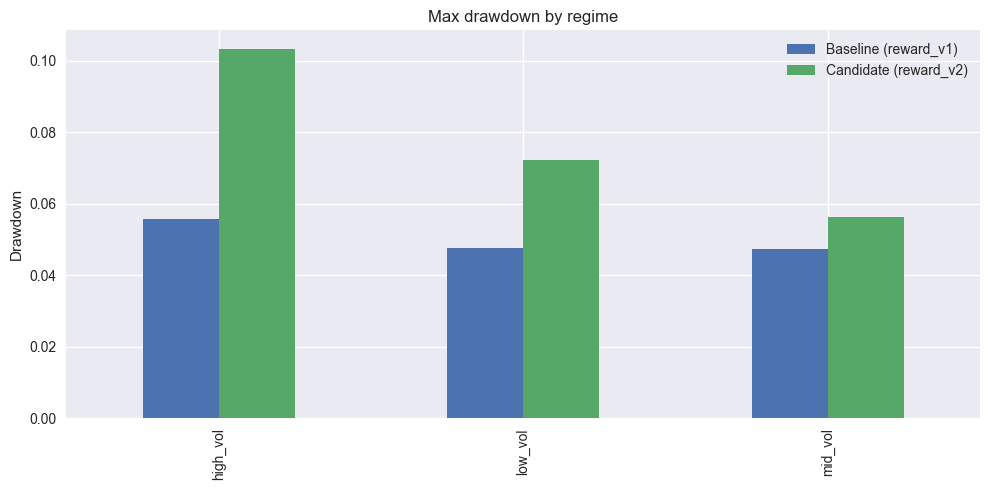

In [6]:
baseline_regime = extract_regime_frame(baseline_artifacts)
candidate_regime = extract_regime_frame(candidate_artifacts)

if baseline_regime.empty and candidate_regime.empty:
    print("No regime slice data available.")
    regime_comparison = pd.DataFrame()
    regime_delta = pd.DataFrame()
    regime_sharpe_fig = None
    regime_drawdown_fig = None
else:
    combined = pd.concat({BASELINE_LABEL: baseline_regime, CANDIDATE_LABEL: candidate_regime}, axis=1)
    regime_comparison = combined
    shared_index = sorted(set(baseline_regime.index) | set(candidate_regime.index))
    regime_delta = candidate_regime.reindex(shared_index) - baseline_regime.reindex(shared_index)
    display(regime_comparison)
    display(regime_delta)

    sharpe_data = pd.DataFrame({
        BASELINE_LABEL: baseline_regime.get("sharpe"),
        CANDIDATE_LABEL: candidate_regime.get("sharpe"),
    })
    regime_sharpe_fig, ax = plt.subplots()
    sharpe_data.plot(kind="bar", ax=ax, title="Sharpe by regime")
    ax.set_ylabel("Sharpe")
    ax.legend()
    plt.tight_layout()

    drawdown_data = pd.DataFrame({
        BASELINE_LABEL: baseline_regime.get("max_drawdown"),
        CANDIDATE_LABEL: candidate_regime.get("max_drawdown"),
    })
    regime_drawdown_fig, ax = plt.subplots()
    drawdown_data.plot(kind="bar", ax=ax, title="Max drawdown by regime")
    ax.set_ylabel("Drawdown")
    ax.legend()
    plt.tight_layout()


,steps,avg_turnover,p95_turnover,max_turnover,max_drawdown,avg_drawdown,total_return,volatility_ann,sharpe,avg_max_weight,avg_top5_weight
label,,,,,,,,,,,
Baseline (reward_v1),1003,0.013773,0.053681,0.153734,0.086705,0.024949,0.152174,0.056816,0.655443,0.069309,0.216260
Candidate (reward_v2),1003,0.009439,0.052063,0.182582,0.103035,0.031972,0.065209,0.063948,0.280371,0.059816,0.190374


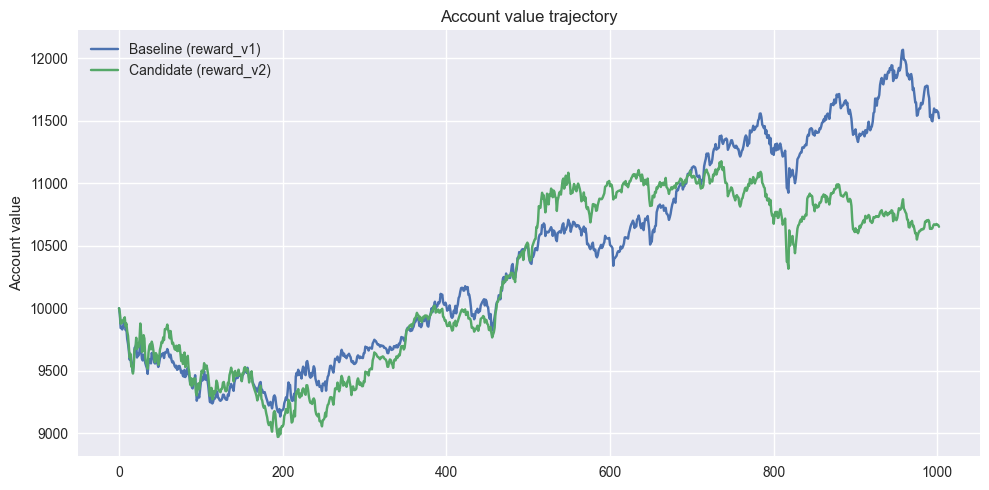

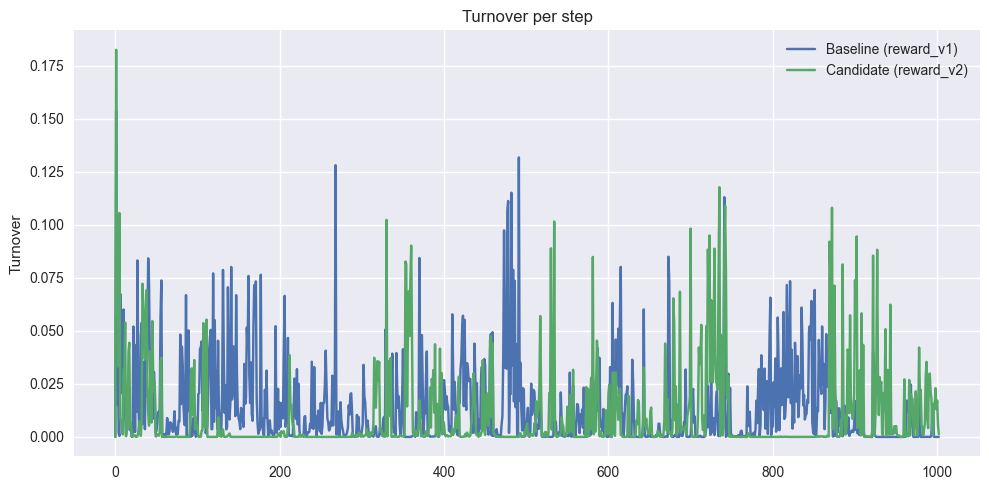

In [7]:
baseline_steps = build_step_frame(baseline_artifacts)
candidate_steps = build_step_frame(candidate_artifacts)
layer3_rows = []
for label, df in [
    (BASELINE_LABEL, baseline_steps),
    (CANDIDATE_LABEL, candidate_steps),
]:
    summary = summarize_stability(df) if not df.empty else {"steps": 0}
    summary["label"] = label
    layer3_rows.append(summary)

layer3_df = pd.DataFrame(layer3_rows).set_index("label")
display(layer3_df)

account_value_fig = None
turnover_fig = None
if not baseline_steps.empty or not candidate_steps.empty:
    account_value_fig, ax = plt.subplots()
    if "account_value" in baseline_steps:
        ax.plot(baseline_steps["account_value"], label=BASELINE_LABEL)
    if "account_value" in candidate_steps:
        ax.plot(candidate_steps["account_value"], label=CANDIDATE_LABEL)
    ax.set_title("Account value trajectory")
    ax.set_ylabel("Account value")
    ax.legend()
    plt.tight_layout()

    turnover_fig, ax = plt.subplots()
    if "turnover" in baseline_steps:
        ax.plot(baseline_steps["turnover"].reset_index(drop=True), label=BASELINE_LABEL)
    if "turnover" in candidate_steps:
        ax.plot(candidate_steps["turnover"].reset_index(drop=True), label=CANDIDATE_LABEL)
    ax.set_title("Turnover per step")
    ax.set_ylabel("Turnover")
    ax.legend()
    plt.tight_layout()
else:
    print("No step-level data available for turnover/drawdown diagnostics.")


In [8]:
summary_lines = []
if not layer1_delta.empty:
    turnover_delta = layer1_delta.get("turnover_realized")
    if turnover_delta is not None and not np.isnan(turnover_delta):
        summary_lines.append(f"Execution: turnover delta {turnover_delta:+.2f} (candidate - baseline).")
    fill_delta = layer1_delta.get("fill_rate")
    if fill_delta is not None and not np.isnan(fill_delta):
        summary_lines.append(f"Execution: fill-rate delta {fill_delta:+.3f}.")
else:
    summary_lines.append("Execution layer lacked comparable metrics.")

if not regime_delta.empty:
    sharpe_gain = regime_delta.get("sharpe")
    if sharpe_gain is not None:
        summary_lines.append(
            "Regime: candidate Sharpe beats baseline in "
            + f"{(sharpe_gain > 0).sum()} / {len(sharpe_gain.dropna())} buckets"
        )
else:
    summary_lines.append("Regime layer missing; cannot assess per-regime gains.")

if not layer3_df.empty:
    turnover_candidate = layer3_df.loc[CANDIDATE_LABEL].get("avg_turnover")
    turnover_baseline = layer3_df.loc[BASELINE_LABEL].get("avg_turnover")
    if turnover_candidate is not None and turnover_baseline is not None:
        summary_lines.append(
            f"Stability: avg turnover changed {turnover_candidate - turnover_baseline:+.3f}."
        )
else:
    summary_lines.append("Stability diagnostics unavailable.")

summary_lines.append("Recommendation: run paired seeds or move to qualification once stable.")

display(Markdown("".join(f"* {line}" for line in summary_lines)))


* Execution: turnover delta -0.91 (candidate - baseline).* Execution: fill-rate delta +0.000.* Regime: candidate Sharpe beats baseline in 0 / 3 buckets* Stability: avg turnover changed -0.004.* Recommendation: run paired seeds or move to qualification once stable.

In [9]:
exports = []
if not layer1_df.empty:
    path = EXPORT_DIR / "layer1_execution_comparison.csv"
    layer1_df.to_csv(path)
    exports.append(path)
if not regime_comparison.empty:
    path = EXPORT_DIR / "layer2_regime_slices_comparison.csv"
    regime_comparison.to_csv(path)
    exports.append(path)
if not regime_delta.empty:
    path = EXPORT_DIR / "layer2_regime_slices_delta.csv"
    regime_delta.to_csv(path)
    exports.append(path)
if not layer3_df.empty:
    path = EXPORT_DIR / "layer3_stability_summary.csv"
    layer3_df.to_csv(path)
    exports.append(path)

plot_pairs = [
    (regime_sharpe_fig, "layer2_regime_sharpe.png"),
    (regime_drawdown_fig, "layer2_regime_drawdown.png"),
    (account_value_fig, "layer3_account_value.png"),
    (turnover_fig, "layer3_turnover.png"),
]
for fig, filename in plot_pairs:
    if fig is not None:
        fig.savefig(EXPORT_DIR / filename, bbox_inches="tight")
        exports.append(EXPORT_DIR / filename)

print("Exported artifacts:")
for path in exports:
    print(" -", path)


Exported artifacts:
 - notebooks/_out/layer1_execution_comparison.csv
 - notebooks/_out/layer2_regime_slices_comparison.csv
 - notebooks/_out/layer2_regime_slices_delta.csv
 - notebooks/_out/layer3_stability_summary.csv
 - notebooks/_out/layer2_regime_sharpe.png
 - notebooks/_out/layer2_regime_drawdown.png
 - notebooks/_out/layer3_account_value.png
 - notebooks/_out/layer3_turnover.png
